## **Step 1 - keywords Extraction**
***

general overview of the work done :

0. obtain a dataset of dreams descriptions.  
1. scrape dream symbols from dreammoods.com   
2. split them into symbol, context and meaning  
3. for each dream in the dreams dataset match 5 best fitting contexts from symbols dataset  
4. construct input promt for the model: for each dream attach the 5 found contexts, with their symbol and interpretation.  
5. take the longest input as a sample input and measure the maximum batch size that the given machine can handle  
6. run the inputs through the model  
7. run evaluations: compare the results vs. the dream description    

We have two datasets, one with dream text descriptions:

In [1]:
test_run = True
test_limit = 10
output_root = "output/test"

In [2]:
from keyword_extractor import read_datasets, extract_and_save_keywords_from_dataframes
from yaml_parser import load_config
config = load_config()
dream_df, keywords_df = read_datasets(config)
dream_df.head()

,dream_id,text_dream,context
0,1,"The one at the Meads's house, where it's bigge...",To dream that you are inside a stranger's hous...
1,2,I'm at a family reunion in a large fine house ...,Dreaming that you are going down a hill;To see...
2,3,I watch a plane fly past and shortly realize i...,To dream that you are having difficulties cont...
3,4,Me pulling the green leaves and berries off so...,Dreaming that you are breaking into someone's ...
4,5,I'm in a room that reminds me of (but definite...,To dream that you are in a dining room;To drea...


The only column we need is text_dream. And dream_id for identification. So we can drop the rest.  

In [3]:
dream_df = dream_df[["dream_id","text_dream","context"]]

And another one with interpretations of dreams according to keywords:

In [4]:

keywords_df.loc[keywords_df.context.isna(),"context"] = keywords_df.loc[keywords_df.context.isna(),"symbol"]
keywords_df["context_len"] = keywords_df.context.str.len()
keywords_df

,symbol,context,meaning,context_len,n_meanings
0,T,To see the letter T in your dream,represents your stubbornness and your refusal...,33,1
1,Table,To see a table in your dream,represents social unity and family connection...,28,6
2,Table,To dream that you are setting the table,suggests that you laying the groundwork for a...,39,6
3,Table,To see a round table in your dream,"indicates evenness, sharing, cooperation, equ...",34,6
4,Table,To dream that you are lying on a table,indicates your need for nourishment and relax...,38,6
...,...,...,...,...,...
7793,Lute,To see or play the lute in your dream,symbolizes pureness and faith.,37,1
7794,Luxury,To dream that you are living in luxury,represents your lavish lifestyle. The dream m...,38,1
7795,Lying,#Ref:liar,#Ref:liar,9,1
7796,Lynching,To see a lynching in your dream,represents feelings of self-guilt.,31,1


In [5]:
# for now, let's drop the #Ref synonyms
keywords_df = keywords_df[~keywords_df.context.str.contains("#Ref")]

In [6]:
keywords_df

,symbol,context,meaning,context_len,n_meanings
0,T,To see the letter T in your dream,represents your stubbornness and your refusal...,33,1
1,Table,To see a table in your dream,represents social unity and family connection...,28,6
2,Table,To dream that you are setting the table,suggests that you laying the groundwork for a...,39,6
3,Table,To see a round table in your dream,"indicates evenness, sharing, cooperation, equ...",34,6
4,Table,To dream that you are lying on a table,indicates your need for nourishment and relax...,38,6
...,...,...,...,...,...
7792,Lust,To dream that someone is lusting after you,means that you think highly of yourself. You ...,42,2
7793,Lute,To see or play the lute in your dream,symbolizes pureness and faith.,37,1
7794,Luxury,To dream that you are living in luxury,represents your lavish lifestyle. The dream m...,38,1
7796,Lynching,To see a lynching in your dream,represents feelings of self-guilt.,31,1


Then, we used a pretrained Sentence transformer to encode the dream embeddings and keyword embeddings and try to extract the most significant keywords from each dream.

### **all-MiniLM-L6-v2**
***

In [7]:
dream_df = extract_and_save_keywords_from_dataframes(dream_df, keywords_df)
dream_df

,dream_id,text_dream,context
0,1,"The one at the Meads's house, where it's bigge...",To dream that you are inside a stranger's hous...
1,2,I'm at a family reunion in a large fine house ...,Dreaming that you are going down a hill;To see...
2,3,I watch a plane fly past and shortly realize i...,To dream that you are having difficulties cont...
3,4,Me pulling the green leaves and berries off so...,Dreaming that you are breaking into someone's ...
4,5,I'm in a room that reminds me of (but definite...,To dream that you are in a dining room;To drea...
...,...,...,...
20995,33062,The dream was about me and my boyfriend going ...,To dream that you fall off a mountain;To dream...
20996,33063,Two weeks ago this guy asked me to Senior Ball...,To dream that you are fishing;To dream that yo...
20997,33064,My boyfriend just broke up with me so he was o...,To dream about a girl that you just met;To dre...
20998,33065,I was in my backyard and I was flying. I would...,To dream that you are soaring through the air;...


To view the dataframe better, We will filter out the interesting columns:

In [8]:
columns_to_show = ['dream_id','text_dream', 'context']
dream_df[columns_to_show]

,dream_id,text_dream,context
0,1,"The one at the Meads's house, where it's bigge...",To dream that you are inside a stranger's hous...
1,2,I'm at a family reunion in a large fine house ...,Dreaming that you are going down a hill;To see...
2,3,I watch a plane fly past and shortly realize i...,To dream that you are having difficulties cont...
3,4,Me pulling the green leaves and berries off so...,Dreaming that you are breaking into someone's ...
4,5,I'm in a room that reminds me of (but definite...,To dream that you are in a dining room;To drea...
...,...,...,...
20995,33062,The dream was about me and my boyfriend going ...,To dream that you fall off a mountain;To dream...
20996,33063,Two weeks ago this guy asked me to Senior Ball...,To dream that you are fishing;To dream that yo...
20997,33064,My boyfriend just broke up with me so he was o...,To dream about a girl that you just met;To dre...
20998,33065,I was in my backyard and I was flying. I would...,To dream that you are soaring through the air;...


In [9]:
from utils import save_df_as_pretty_html
save_df_as_pretty_html(dream_df[columns_to_show][:2000],  "html/dreams_with_context.html")
dream_df[columns_to_show].to_csv("datasets/dreams_with_context.csv", index=False)

✅ HTML table saved to: html/dreams_with_context.html


In [10]:
dream_df


,dream_id,text_dream,context
0,1,"The one at the Meads's house, where it's bigge...",To dream that you are inside a stranger's hous...
1,2,I'm at a family reunion in a large fine house ...,Dreaming that you are going down a hill;To see...
2,3,I watch a plane fly past and shortly realize i...,To dream that you are having difficulties cont...
3,4,Me pulling the green leaves and berries off so...,Dreaming that you are breaking into someone's ...
4,5,I'm in a room that reminds me of (but definite...,To dream that you are in a dining room;To drea...
...,...,...,...
20995,33062,The dream was about me and my boyfriend going ...,To dream that you fall off a mountain;To dream...
20996,33063,Two weeks ago this guy asked me to Senior Ball...,To dream that you are fishing;To dream that yo...
20997,33064,My boyfriend just broke up with me so he was o...,To dream about a girl that you just met;To dre...
20998,33065,I was in my backyard and I was flying. I would...,To dream that you are soaring through the air;...


## Step 2 - Summarize interpretations

After extracting the meaningful keywords, we tried to fetch the matching interpretation for each extracted keyword and use a pretrained LLM to summarize these interpretations into one interpretation.

### Load data and prepare (small) dataset for experimenting

In [11]:
import pandas as pd
import pandasql as ps
from plotly import express as px
from datetime import datetime
from transformers import pipeline
from utils import  release_all_gpu_memory, save_df_as_pretty_html
from summarizer import load_causal_model, batch_generate_interpretations
from summarizer import format_input, attach_meanings, PromptFormatter
import torch


In [12]:
dream_df = attach_meanings(dream_df, keywords_df)

In [13]:
dream_df

,dream_id,text_dream,context,meanings
0,1,"The one at the Meads's house, where it's bigge...",To dream that you are inside a stranger's hous...,- Trick or Treating: To dream that trick or t...
1,2,I'm at a family reunion in a large fine house ...,Dreaming that you are going down a hill;To see...,- Fainting: To dream that you are fainting su...
2,3,I watch a plane fly past and shortly realize i...,To dream that you are having difficulties cont...,- Family: Dreaming that a serial killer is ki...
3,4,Me pulling the green leaves and berries off so...,Dreaming that you are breaking into someone's ...,- Trick or Treating: To dream that trick or t...
4,5,I'm in a room that reminds me of (but definite...,To dream that you are in a dining room;To drea...,- Dining Room: To dream that you are in a din...
...,...,...,...,...
20995,33062,The dream was about me and my boyfriend going ...,To dream that you fall off a mountain;To dream...,- Fall: To dream that you fall and are not fr...
20996,33063,Two weeks ago this guy asked me to Senior Ball...,To dream that you are fishing;To dream that yo...,- Trout: To see a trout in your dream symboli...
20997,33064,My boyfriend just broke up with me so he was o...,To dream about a girl that you just met;To dre...,- Boy: If you are female and dream that you s...
20998,33065,I was in my backyard and I was flying. I would...,To dream that you are soaring through the air;...,- Trampoline: To dream that you are jumping o...


In [14]:
save_df_as_pretty_html(dream_df[:1000],"html/dreams_with_context_and_meanings.html")

✅ HTML table saved to: html/dreams_with_context_and_meanings.html


In [15]:
dream_df.to_csv("datasets/dreams_with_context_and_meanings.csv", index=False)


Now, we will create a prompt for the LLM. The prompt will include a request for the LLM to summarize the interpretations. It will get the dream description, the keywords, and the interpretations.

### Summarize with flan-T5-large model

In [16]:
release_all_gpu_memory()

['model', 'tokenizer', 'text2text_generator']
clearing cuda cache
clearing ipc cache
✅ All GPU memory cleared.


In [17]:
# Use this cell to re-import a function in case you've updated it's code in summarizer.py
from importlib import reload
import summarizer
reload(summarizer)

# Now re-import manually
from summarizer import *


In [44]:
# Step 1: Load FLAN-T5 model and tokenizer
model_name = "google/flan-t5-large"
model_family="encoder"
prompt = "Interpret this dream: "

model_name_short = model_name.split("/")[-1]
device = 0 if torch.cuda.is_available() else -1
model, tokenizer = load_causal_model(model_name)
formatter = PromptFormatter(model_family)

dataset = format_input(dream_df, prompt, formatter, tokenizer)

formatting input


In [19]:
#dataset = pd.read_csv("datasets/dreams_with_context_and_meanings.csv")

In [45]:
dataset

,dream_id,text_dream,context,meanings,input,len,input_tokens_len,hash
7235,8655,I had bought Grandma F's house to save it from...,To fix an appliance in your dream;To see a bak...,- Bake-house: To see a bake-house in your dre...,Interpret this dream: I had bought Grandma F's...,24057,5730,2d83c327596748dd92cec8e77ce640d2
6646,7939,I was working for SVH. I had two sons. One was...,To dream of sibling rivalry;Ditch;To dream tha...,- Father: To dream that your father is angry ...,Interpret this dream: I was working for SVH. I...,14012,3327,73a02160761b3a2367e43c9afc05aa1a
7439,8900,Matthew and I are at Kings Island. We hadn't g...,To dream that the rides at the amusement park ...,- Carnival: To dream that you are on a carniv...,Interpret this dream: Matthew and I are at Kin...,14108,3285,d2765ccb296f4e5c09b30b4845267dc7
15873,20270,The dream started off in sort of an ancient Gr...,To dream that you are in a maze;To dream that ...,- Tomb: To dream that you are trapped in a to...,Interpret this dream: The dream started off in...,12307,3011,326eea1500a6caaf4a66ebedcc486957
6602,7885,I was the housekeeper for a man and his young ...,To dream that you have a husband (but you do n...,- Child: To dream that you lose a child repre...,Interpret this dream: I was the housekeeper fo...,13076,3007,1eafdb46fa4b8c6171b9aa07a2a2bc44
...,...,...,...,...,...,...,...,...
9441,12148,I went to the movies and took my favourite jum...,To see or wear a life jacket in your dream;To ...,- Chicken Suit: To dream that you are wearing...,Interpret this dream: I went to the movies and...,990,232,033dd3f126dab1121f8d6cf874d2c2fb
13878,17762,Shopping With Jane Rock I am at the Quaint Bo...,Fishing;To dream that you got something at a c...,- Fish Market: To dream that you go to a fish...,Interpret this dream: Shopping With Jane Rock ...,989,231,fe8bad2a833855345b03cc99adb42df0
20920,32983,I was lying down in my bed and my mom was on t...,To dream that you are possessed by demons;To h...,- Ghost: To dream that you turn into a ghost ...,Interpret this dream: I was lying down in my b...,905,223,34b9834d19b986162d5c30c0377b773e
6041,7096,What can I do with this heavy pack of old maga...,Dreaming about a gun magazine;To open a gift a...,- Bag: To dream of a bag full of junk symboli...,Interpret this dream: What can I do with this ...,859,213,094bbd56f16e75fa7212f04e5bb3e145


In [46]:
# filter dataset only to inputs of size that we can handle
dataset = dataset[dataset["input_tokens_len"] <500]

In [47]:
if test_run:
    dataset = dataset[:test_limit]

In [48]:
dataset

,dream_id,text_dream,context,meanings,input,len,input_tokens_len,hash
17697,23152,I dreamed that I was sick and was having a dre...,To dream about a former crush;To dream that yo...,- Crush: To dream about a former crush refers...,Interpret this dream: I dreamed that I was sic...,2103,499,ac2dd9a2a62370529de54cfb6de89a6b
6554,7824,The power went out. I got my flashlight but th...,"According to the biblical interpretations, ant...",- Flashlight: To see a flashlight in your dre...,Interpret this dream: The power went out. I go...,2147,499,f61cb62f1b83ddcfc9f83aa21f031375
11318,14956,This teen guy and his grandmother went missing...,To see decayed and rotting fish at the fish ma...,- Fish: To dream that you are cleaning fish s...,Interpret this dream: This teen guy and his gr...,2062,499,56f10f14f6ea98dc5b1c5325d9682b7d
3859,4432,"(03/08/00)[""Scary forest.""] I am with a group ...",To dream that an unusually large fish is attac...,- Break-In: If the birds are trying to break ...,"Interpret this dream: (03/08/00)[""Scary forest...",2067,499,a1c8ab71879f8ff4bec75f78c435c0ee
13054,16826,"I was with Julie, we were making love on the c...",To see someone dying in your dream;To see the ...,- Ghost: To see the ghost of a dead friend/re...,"Interpret this dream: I was with Julie, we wer...",2242,499,2aa0a58e1d25f031a05e9a2dde83043f
4666,5280,I was on the hill and a lady called me to come...,To dream of a confrontation;To see a boy scout...,- Talking: TalkingTo dream that you are talki...,Interpret this dream: I was on the hill and a ...,2152,499,2a384aa28a40f9ebe1f606a0ba630624
20027,25893,"I was coming home from somewhere. (""Home,"" in...",To dream that you are playing football or on a...,- Tackle: To dream that you are being tackled...,Interpret this dream: I was coming home from s...,2134,499,3a1da6b2edf50b498dc820c08006d554
5143,5850,The only dream I remember is a very explicit s...,Dreaming that your young daughter was raped;To...,- Rape: To dream that you were raped or almos...,Interpret this dream: The only dream I remembe...,2057,499,197bdb7b57d277fad4b620272d15b042
8640,11197,"We were eating at the dormitory, but instead o...",To see or eat spaghetti in your dream;To make ...,- Cafeteria: To dream that you are in a cafet...,Interpret this dream: We were eating at the do...,2190,499,718c2608e48d55acac9dbf0d04d68797
4760,5386,I dreamed that I was in the main building and ...,To dream that a dog bites you on the leg;Dream...,- Flies: Dreaming of a room full of flies ind...,Interpret this dream: I dreamed that I was in ...,1935,499,9cdf3e7cc471b0661d0f043171e71ce8


In [49]:
text2text_generator = pipeline(
        "text2text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=1024,           # ✅ allow longer input
        truncation=True,           # ✅ ensure truncation at tokenizer level
        device=device,
    )

Device set to use cuda:0


Create interpretations in batches:

In [50]:
tstp = datetime.now().strftime(r"%y.%m.%d-%H")
batch_generate_interpretations(dataset, text2text_generator, input_column="input",
                                           batch_size=100, save_dir = output_root + "/FlanT5")


✅ Already processed: 4 / 10 entries


Generating batches: 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]

🏁 Batch generation complete.


We saw that the interpretations are not quite good, and not that related to the dream description. We tried to save the dataframe for further research and saw that the problem applies to many cells and tried another model called Mistral.

### Summarize with Mistral model

In [26]:
from summarizer import load_mistral_4bit_model, find_max_batch_size
print("Loading Mistral-7B-Instruct in 4-bit...")
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_family="decoder"
prompt = """Given dream description, interpret the meaning of the dream. 
    Provided also are the dream symbols that appear in the dream and their meanings. 
    Use the dream symbols meanings to help you interpret the dream. """.replace("\n", " ")

model_name_short = model_name.split("/")[-1]
model, tokenizer = load_mistral_4bit_model(model_name)
formatter = PromptFormatter(model_family)
# max_new_tokens=256         max_new_tokens=max_new_tokens,

dataset = format_input(dream_df, prompt, formatter, tokenizer)

Loading Mistral-7B-Instruct in 4-bit...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

formatting input


In [27]:
# filter dataset only to inputs of size that we can handle
dataset = dataset[dataset["input_tokens_len"] <500]

In [28]:
if test_run:
    dataset = dataset[:test_limit]

In [29]:
dataset

,dream_id,text_dream,context,meanings,input,len,input_tokens_len,hash
10704,14258,I was at school. Everyone was in this room. I ...,To see old classmates in your dream;To dream a...,- Classmates: To see old classmates in your d...,"### Instruction:\nGiven dream description, int...",2139,499,ce219f5b2fb2ae3d616c4482da67ee71
6067,7144,"Sitting at my desk, I ask her if the bell has ...",To dream that you are dressed as a Chinese tak...,- Takeout: To dream that you are dressed as a...,"### Instruction:\nGiven dream description, int...",2117,499,8c5908fb47d8a99d51bb0cce008c2b98
14571,18564,Giving Kevin Advice I'm on the phone with my ...,To dream that you are giving advice;To dream t...,- Basement: To dream that you are in a baseme...,"### Instruction:\nGiven dream description, int...",2110,499,e9fefc013826e145b8218184dc100939
18173,23635,I dreamed I saw a house whose eaves were burni...,To dream that a house is on fire;To dream abou...,- Fire: To dream that you are being burned by...,"### Instruction:\nGiven dream description, int...",2225,499,09eb33b90ff77e29b1c279f26842a199
15031,19092,I had driven to another city to visit my frien...,Dreaming about your friend's friend;If you dre...,- Friend: Dreaming about your friend's friend...,"### Instruction:\nGiven dream description, int...",2146,499,51c61f9a3fd0c3b7914146798bbc0a66
7004,8388,There were two groups of people competing in a...,To dream that you are wearing different hats;T...,- Top Hat: To see or wear a top hat in your d...,"### Instruction:\nGiven dream description, int...",2106,499,3eb898ec3dbcc24f961130f0dbceaf3e
6004,7032,"As J. and I leave the hotel, father tells us t...",To see your father wrapped in bandages from he...,- Grandchild: To see your grandchild in your ...,"### Instruction:\nGiven dream description, int...",2179,499,778970d140d92c58b486fddd07e2e8e4
18188,23650,"I, the dreamer, approached Mr. Harry Schenk, a...",To dream that you forget to attend a class you...,- Teacher: To dream that you are a teacher in...,"### Instruction:\nGiven dream description, int...",2249,499,f74ea5b97626c9ff89f6c00cabffd0c0
1116,1243,I'm building a fire in a fireplace. The floor ...,To dream of lighting or stirring a fireplace;T...,- Fire: To dream that you are being burned by...,"### Instruction:\nGiven dream description, int...",2062,499,2c5b600defdb7b2fb7ab158984336575
10302,13746,We went to some old friend of ours' place. The...,To see the ghost of a dead friend/relative in ...,- Ghost: To see the ghost of a living relativ...,"### Instruction:\nGiven dream description, int...",2109,499,898e05ca6a067c6c8decb79b0cf233c5


#### measure maximum batch size a given machine can hadle without OOMing


In [30]:
sample_prompt = dataset.input.iloc[0]
print(f"Sample prompt length (characters): {len(sample_prompt)}")
if not test_run:
    optimal_batch_size = find_max_batch_size(model, tokenizer, sample_prompt, max_possible=2048, max_new_tokens=512, ) # TODO: measure with max_new_tokens

Sample prompt length (characters): 2139


first run on 24 Gb GPU: 
```
Sample prompt length (characters): 2437  
Trying batch_size = 512... ❌ OOM  
Trying batch_size = 256... ❌ OOM  
Trying batch_size = 128... ❌ OOM  
Trying batch_size = 64... ❌ OOM  
Trying batch_size = 32... ✅ success  
Trying batch_size = 48... ✅ success  
Trying batch_size = 56... ✅ success  
Trying batch_size = 60... ❌ OOM  
Trying batch_size = 58... ❌ OOM  
Trying batch_size = 57... ✅ success  

✅ Optimal batch size: 57
```

In [31]:
# Clear memory after benchmarking
release_all_gpu_memory(["model","model_pipeline","dataloader"])

['model', 'tokenizer', 'text2text_generator', 'model', 'model_pipeline', 'dataloader']
clearing cuda cache
clearing ipc cache
✅ All GPU memory cleared.


### Run the pipeline on the whole dataset

In [32]:
optimal_batch_size = 40

model_pipeline = pipeline(
        "text-generation",
        model=model,
        batch_size=optimal_batch_size,
        tokenizer=tokenizer,
        #max_length=1024,  
        max_new_tokens=512,         # ✅ controls output size
        truncation=True,            # ✅ safely truncates long inputs
        return_full_text=False,     # ✅ excludes input from output
        do_sample=False
    )


Device set to use cuda:0


In [33]:
# Use this cell to re-import a function in case you've updated it's code in summarizer.py
from importlib import reload
import summarizer
reload(summarizer)

# Now re-import manually
from summarizer import batch_generate_interpretations


In [34]:

print("\n🧠 Running interpretations...")
tstp = datetime.now().strftime(r"%y.%m.%d-%H")

batch_generate_interpretations(dataset, model_pipeline, save_dir=output_root + "/Mistral",
                               input_column="input", output_column="interpretation", 
                               batch_size=optimal_batch_size)
#print(result_df[["dream", "interpretation"]])



🧠 Running interpretations...
✅ Already processed: 0 / 10 entries


Generating batches: 100%|██████████| 1/1 [07:53<00:00, 473.53s/it]

🏁 Batch generation complete.


# Memory investigation

In [35]:
from utils import globals_snapshot

tps = globals_snapshot()

q = """
select type, count(var) as cnt
from tps
group by type 
order by cnt desc 

"""
df = ps.sqldf(q)
df

,type,cnt
0,<class 'str'>,4
1,<class 'function'>,4
2,<class 'dict'>,1
3,<class '_frozen_importlib_external.SourceFileL...,1
4,<class '_frozen_importlib.ModuleSpec'>,1
5,<class 'NoneType'>,1


It didn't seem to help... So we then tried to improve our keyword extraction using:
1. First - semantic search to narrow down the search of the keywords to only the semantically close ones.
2. Second - MMR (Maximal Marginal Relevance) to increase the diversity of keywords extracted from the dream.

#TODO: Summarize better_keywords_extraction.ipynb

## **Evaluation**
***

We evaluated the performance of the dream interpretation using BLEU,perplexity,ROUGE, and BERT. **It's important to mention: evaluation was tested on a small sample of 5 rows, and also the dream interpretation was compared to the dream itself and that might be the reason for the small values of the metrics**

### Flan-T5

In [ ]:
from evaluation import evaluate_dream_interpretations
from utils import read_csvs, plot_evaluations
from summarizer import PromptFormatter
model_family="encoder"

formatter = PromptFormatter(model_family)

In [ ]:
dataset = read_csvs(save_dir = output_root + "/FlanT5")
dataset["meaning"] = dataset.interpretation.apply(formatter.unformat)
dataset = dataset[["dream", "symbols", "meaning"]]
dataset

,dream,symbols,meaning
0,I was at this place and everyone from school w...,- Ghost: To see a ghost in your dream repres...,Everyone from school was there. There was a gh...
1,"A LT event of some sort, in a small school aud...",- Baby Shower: To dream of a baby shower sug...,"LT event of some sort, in a small school audit..."
2,Looking across I see mother in a window whippi...,- Baby Carriage: To see a baby carriage in y...,A mother is whipping her son.
3,I was lacing my shoes and my shoestrings were ...,- Barbed Wire: To see barbed wire in your dr...,The dreamer is lacing his shoes and his shoest...
4,"I was playing soccer on a huge field, and the ...",- Ball: To see or play with a ball in your d...,The dreamer is playing soccer on a huge field.
...,...,...,...
95,I see that I am in the university yard and see...,- Abscess: To dream that you have an abscess...,Abscess: To dream that you have an abscess sug...
96,I was at this place that we went to regularly....,- Koala: To see a koala in your dream repres...,The dreamer is a snake.
97,I dreamed I was playing the guitar with a frie...,- Band: To see a band or play with a band in...,A friend is learning how to play the guitar. T...
98,Meat: $27 Per Pound I'm at Cub Foods shopping...,- Ham: To dream that you are eating ham indi...,A man wants some meat that costs $27 per pound...


In [38]:
dreams_interpretations_df = evaluate_dream_interpretations(dataset, interpretation_column = 'meaning')
dreams_interpretations_df.to_csv('datasets/flan-t5-large_evaluated.csv', index=False)


/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

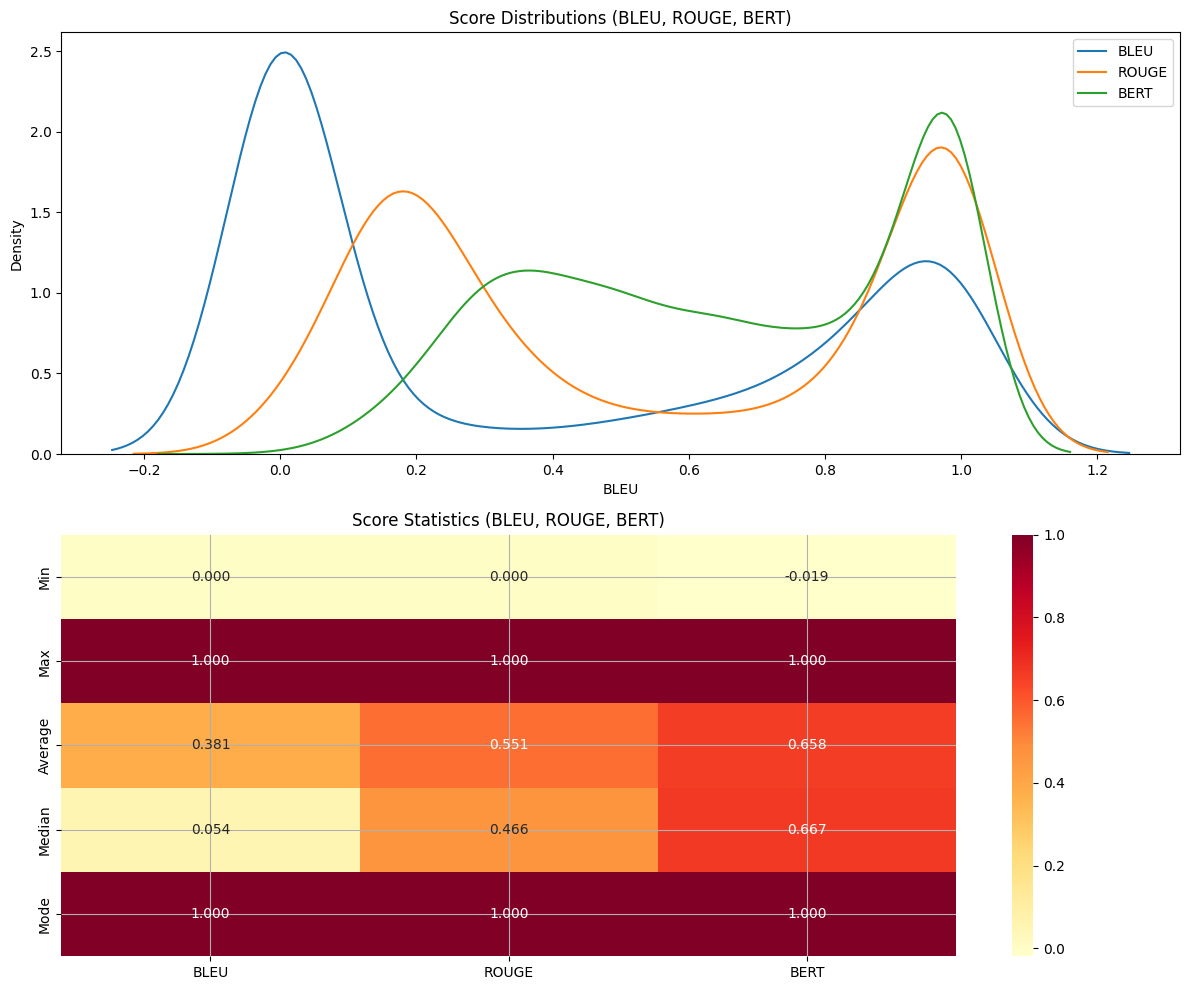

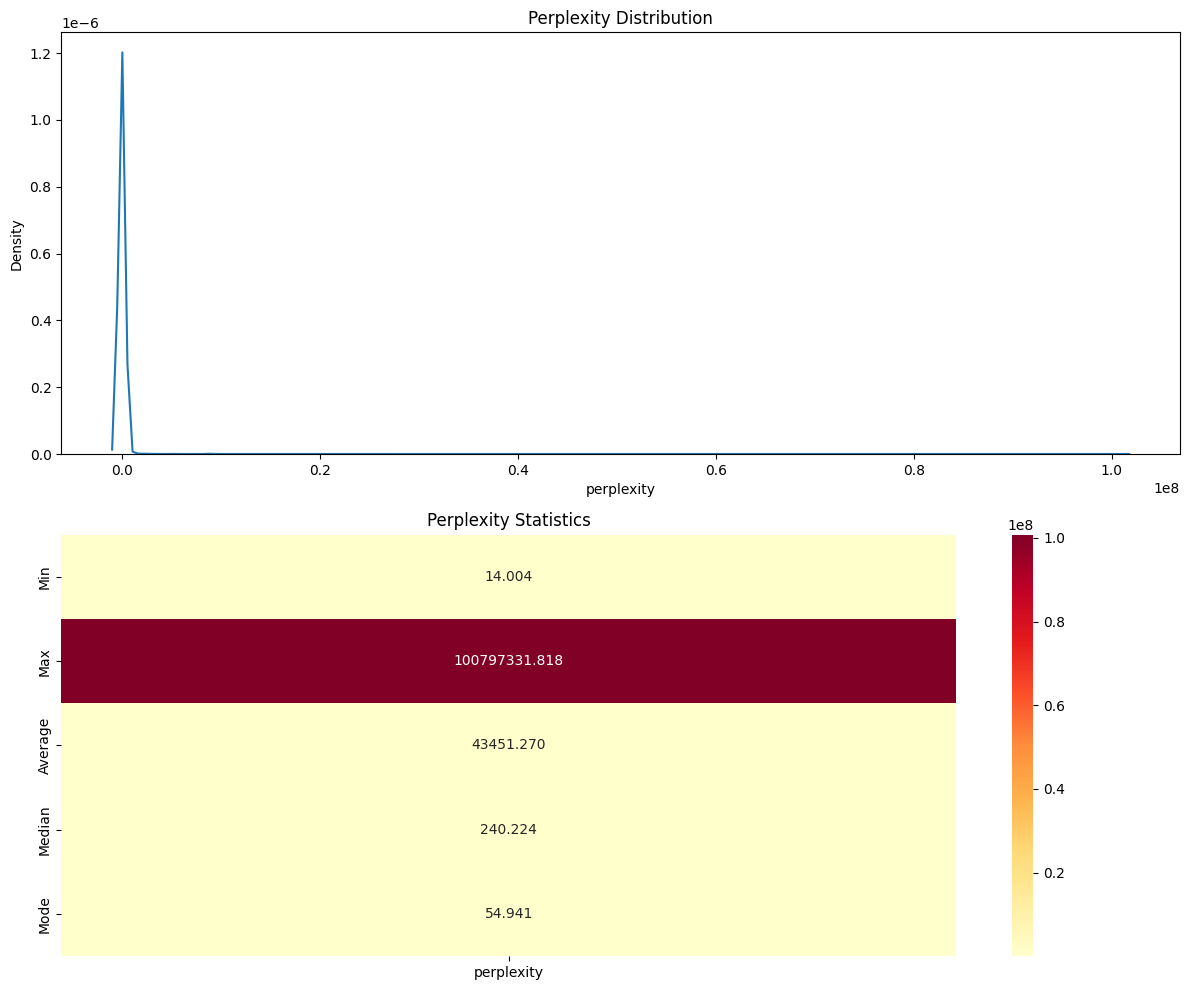

In [ ]:

plot_evaluations(dreams_interpretations_df)


### Mistral

In [40]:
from evaluation import evaluate_dream_interpretations
from utils import read_csvs
from summarizer import PromptFormatter
model_family="decoder"

formatter = PromptFormatter(model_family)

In [ ]:
dataset = read_csvs(save_dir = output_root + "/Mistral")
dataset["meaning"] = dataset.interpretation.apply(formatter.unformat)
dataset = dataset[["dream", "symbols", "meaning"]]
dataset

,dream,symbols,meaning
0,I was with some friends on a street and we wer...,- Abduction: To dream of being abducted indi...,The dream starts with the dreamer and her frie...
1,"I liked this guy, though he was dating someone...",- Abduction: To dream of being abducted indi...,The dreamer is attracted to a man who is alrea...
2,I was in New York sitting in on a radio broadc...,- Camping: To dream that you are camping ind...,"The dreamer is in New York, which could repres..."
3,"I am traveling through the countryside, on the...",- Hamlet: To see Hamlet in your dream refers...,The dreamer is traveling through the countrysi...
4,Romeo and Juliet I'm in a room with my housem...,- Hamlet: To see Hamlet in your dream refers...,"The dreamer is in a room with two other men, o..."
...,...,...,...
35,The predominant background for the dreams prac...,- Hallucination: To have a hallucination in ...,"The dreamer describes a scene of inactivity, w..."
36,I was at university. It was Tuesday and I had ...,- Cafeteria: To dream that you are in a cafe...,"The dreamer is in a university setting, which ..."
37,I was in the passenger seat of my family's old...,- Abandonment: To dream that you are abandon...,The dream is about feeling abandoned and betra...
38,At a party of some kind I meet a girl known fr...,"- Kiss: To dream of a kiss denotes love, aff...",The dream is about unrequited love and insecur...


In [42]:
dreams_interpretations_df = evaluate_dream_interpretations(dataset, interpretation_column = 'meaning')
dreams_interpretations_df.to_csv('datasets/Mistral-7B-Instruct-v0.2_evaluated.csv', index=False)


/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

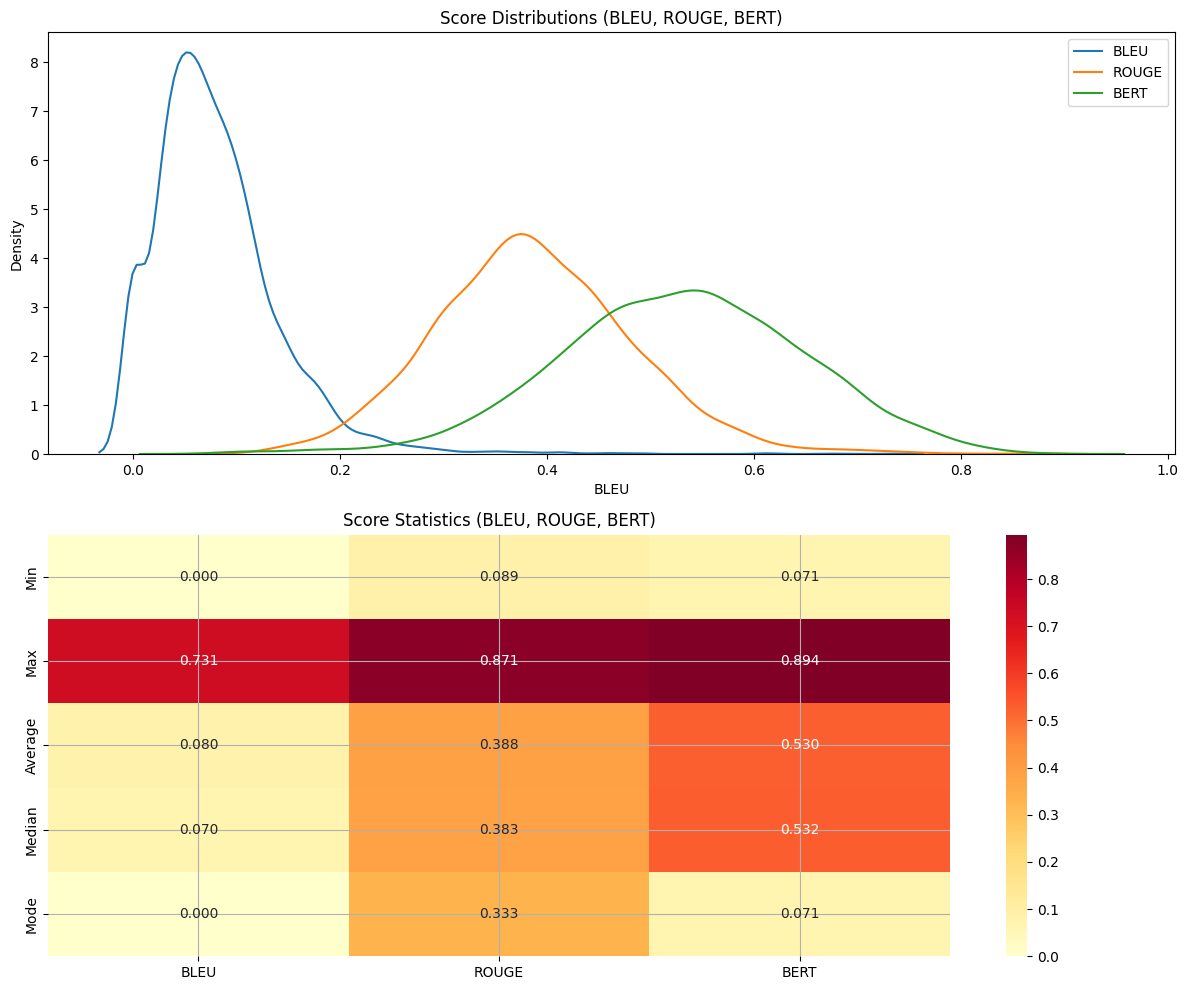

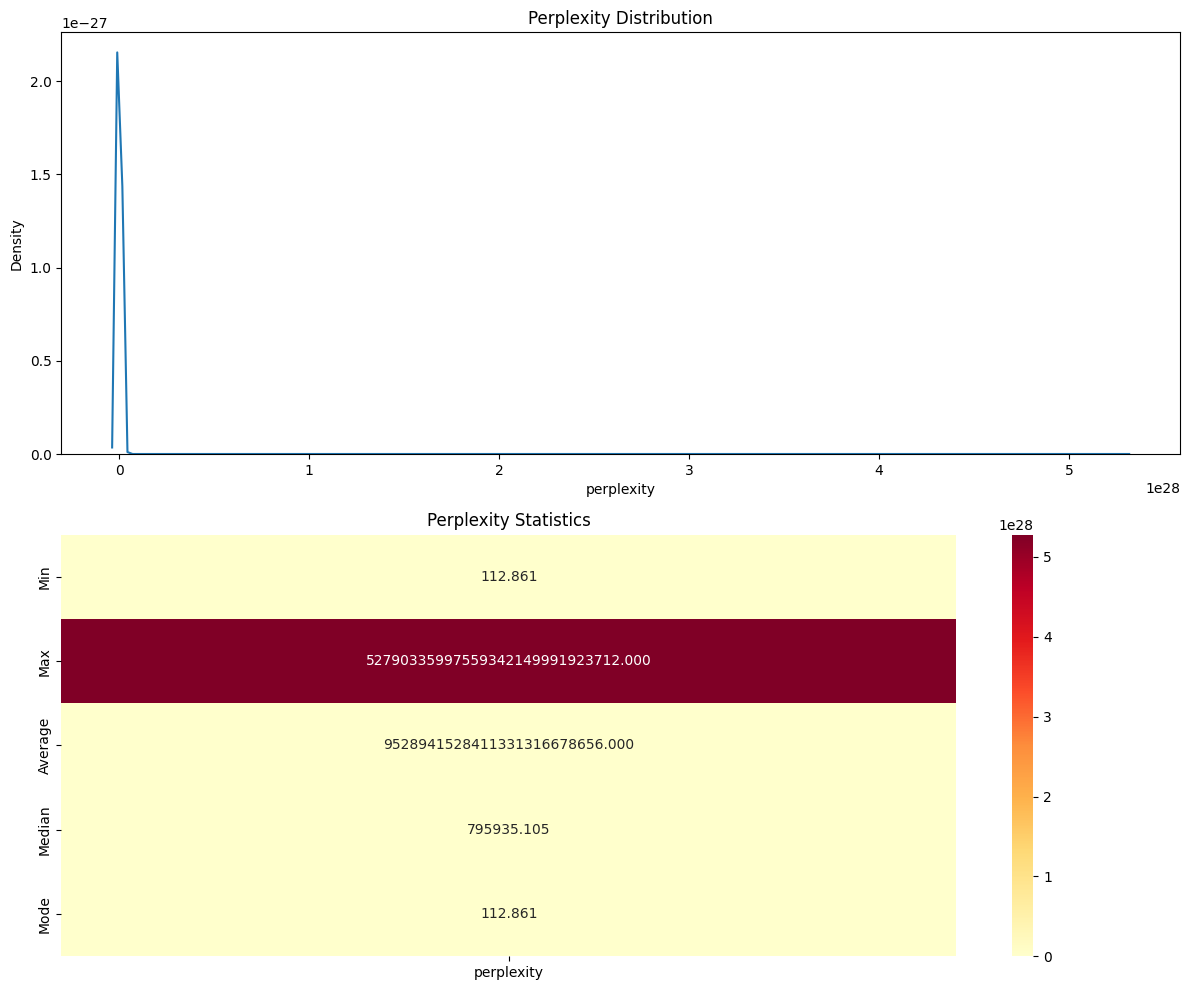

In [ ]:
plot_evaluations(dreams_interpretations_df)


We can draw the following conclusions:
1. The bleu score is incredibly low (a good result should be 20-40, we didn't even get 1...). This means that there is a weak overlap between the dream and its interpretation.
2. Same for the Rouge.
3. BERT averages at 0.6, which is not that bad considering that a good value is 0.85–0.9 that indicates some semantic similarity between the dream and its interpretation.
4. perplexity is terrible since a good value is under 20...
5. We interpret the results using this table:


| **Metric** | **High Score Meaning** | **Low Score Meaning** | **Preferred Score** | **Typical Values for Good Results** | **Why?** |
| --- | --- | --- | --- | --- | --- |
| **BLEU** | High n-gram overlap between reference and candidate text | Low n-gram overlap between reference and candidate text | **High** | 20–40 (moderate), 40+ (good) | High BLEU indicates the candidate text closely matches the reference text. |
| **Perplexity** | Candidate text is unpredictable and diverges from reference distribution | Candidate text is predictable, fluent, and aligned with reference distribution | **Low** | < 20 (for good results) | Low perplexity shows that the candidate text is fluent, consistent, and aligned with the reference. |
| **ROUGE** | More overlapping n-grams (e.g., unigrams, bigrams) and higher recall of key phrases | Fewer overlapping n-grams and poor recall of key phrases | **High** | 30–50 (good), 50+ (very good) | High ROUGE suggests greater similarity between the candidate and reference texts. |
| **BERTScore** | Strong semantic similarity between the candidate and reference text | Weak semantic similarity between the candidate and reference text | **High** | 0.85–0.98 (good) | Higher BERTScore reflects that the candidate preserves the meaning of the reference text. |

